In [15]:
#Importing libraries
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import seaborn as sns
%matplotlib inline

In [16]:
np.random.seed(42)

In [17]:
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Entering Stocks
### We will let the user enter the following
#### 1. Stocks
#### 2. Weights (optional)
#### 3. Start date of historical data
#### 4. End date of historical data 
#### 5. Number of simulations
#### 6. Number of years

In [18]:
init_invstmnt = int(input('Enter your initial investment:'))
print(f'your initial investment is: ${init_invstmnt}')

Enter your initial investment: 50000


your initial investment is: $50000


In [25]:
#User stocks input
#CODE:
text = input('Enter Stocks separated by comma, up to five stocks only')
test = text.split(',')

Enter Stocks separated by comma, up to five stocks only AAPL,AMZN,GOOG,MSFT


In [6]:
#User weights input
#CODE:

#weights = input('Enter weights: ')
#weights = list(map(float,weights.split(',')))
#print(weights)

In [20]:
#User start date of historical prices input
#CODE
start_date = input('Enter Start Date: e.g. 2018-01-01: ')
print(f'your start date is: {start_date}')

Enter Start Date: e.g. 2018-01-01:  2018-01-01


your start date is: 2018-01-01


In [21]:
#User end date of historical prices input
#CODE
end_date = input('Enter End Date: e.g. 2019-01-01')
print(f'your end date is: {end_date}')

Enter End Date: e.g. 2019-01-01 2019-01-01


your end date is: 2019-01-01


In [22]:
#User number of simulaitons input
#CODE
number_simulations = int(input('Enter number of simulations: '))
print(f'number of simulations is {number_simulations}')

Enter number of simulations:  20


number of simulations is 20


In [23]:
#User number of years input 
#CODE
number_years = int(input('Enter number of years:'))

Enter number of years: 30


In [26]:
#Importing Data and cleaning
#CODE
spy = ("SPY")
list_of_tickers = text.split(',')
# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
#end_date = datetime.now()
#start_date = end_date + timedelta(-365*100)

start_date = pd.Timestamp(start_date, tz='America/New_York').isoformat()
end_date = pd.Timestamp(end_date, tz='America/New_York').isoformat()
df = api.get_barset(
    list_of_tickers+['SPY'], 
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df
df = df.sort_index()
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df = df.droplevel(axis=1, level=1)
df.index = df.index.date
df.dropna(inplace=True)
spy_df = df['SPY']
df.drop(columns='SPY',inplace=True)
print(df.tail())


              AAPL     AMZN     GOOG      MSFT
2018-12-24  146.62  1342.91   975.00   94.0400
2018-12-26  157.18  1470.81  1039.19  100.5300
2018-12-27  156.12  1462.00  1043.89  101.0500
2018-12-28  156.07  1475.18  1036.20  100.3487
2018-12-31  156.70  1492.38  1029.11  100.8300


In [27]:
# Calculate the daily returns for the given stocks closing prices
#CODE
means = {}
daily_returns = df.pct_change()
daily_returns.dropna(inplace=True)

for stock in list_of_tickers:
    print(stock)
    means[stock] = daily_returns.mean()[stock]
    print(f'{stock} mean: {means[stock]}')

AAPL
AAPL mean: -0.00021250953939727112
AMZN
AMZN mean: 0.0011707734649056127
GOOG
GOOG mean: 2.176086064539051e-05
MSFT
MSFT mean: 0.0007977924615533376


In [28]:
# Volatility for the given stocks closing prices
#CODE
std = {}
for stock in list_of_tickers:
    print(stock)
    std[stock] = daily_returns.std()[stock]
    print(f'{stock} std: {std[stock]}')

AAPL
AAPL std: 0.018249444944860638
AMZN
AMZN std: 0.022885160247310295
GOOG
GOOG std: 0.017801507907868688
MSFT
MSFT std: 0.01777214106274319


In [29]:
# Last day's closing price for the stocks and save those as variables
#CODE
last_day = {}
for stock in list_of_tickers:
    print(stock)
    last_day[stock] = df[stock][-1]
    print(f'{stock} last days closing price: {last_day[stock]}')

AAPL
AAPL last days closing price: 156.7
AMZN
AMZN last days closing price: 1492.38
GOOG
GOOG last days closing price: 1029.11
MSFT
MSFT last days closing price: 100.83


### SPY:

In [30]:
# SPY daily returns 
daily_returns_spy = spy_df.pct_change()
daily_returns_spy.dropna(inplace=True)
mean_spy=daily_returns_spy.mean()
print('SPY mean:',mean_spy)

SPY mean: -0.0002552590605204479


In [31]:
# SPY Volatility 
spy_std = daily_returns_spy.std()
print('SPY std:',spy_std)

SPY std: 0.010771437761174724


In [32]:
# SPY Last day's closing price
spy_last_day = spy_df[-1]
print(spy_last_day)

248.55


## Run Monte Carlo Simulation:
#### - We run (n) simulations, using Monte Carlo Algorithms to simulate future prices
#### - After computing the simulated prices, we get to the portfolio average return individual stocks, so we weight stocks in the portfolio
#### - We create an empty list for the Monte Carlo optimal weights
#### - Each simulation has its own optimal weights, therefore, we create a variable to hold the weights so we can save them to calculate the average 
#### - instead of computing weights manually, we can find the optimal weights that maximize Sharpe ratio mathematically using optimization technique (using SciPy)
#### - Given the simulated prices, we use SciPy's built-in optimization algorithms to calculate the optimal weights


In [33]:
# Setup the Monte Carlo

#number_simulations = 500
number_records = (number_years * 252) 
monte_carlo = pd.DataFrame()
monte_carlo_spy = pd.DataFrame()
number_records


# We need to keep the optimal weights in order to calculate the average 
mc_opt_weights= []
# we create variable 'simulated_dr_all' to save the daily returns of the simulated prices to use it with the average weights later
simulated_dr_all = []


simulated_prices_all = {stock:pd.DataFrame() for stock in list_of_tickers}
simulated_prices_spy_all = pd.DataFrame()

#Monte Carlo simulation


for x in range(number_simulations):
    
    # Initialize the simulated prices list with the last closing price 
    simulated_prices = {stock:[last_day[stock]] for stock in list_of_tickers}
    simulated_prices_spy = [spy_last_day]
    
    for i in range(number_records):
        for stock in list_of_tickers:
            simulated_price = simulated_prices[stock][-1] * (1 + np.random.normal(means[stock], std[stock]))

            simulated_prices[stock].append(simulated_price)
            
        simulated_spy = simulated_prices_spy[-1] * (1 + np.random.normal(mean_spy, spy_std))
        simulated_prices_spy.append(simulated_spy)
        
    for stock in list_of_tickers:
        simulated_prices_all[stock][x] = pd.Series(simulated_prices[stock])
    simulated_prices_df = pd.DataFrame(simulated_prices)
 
 
    simulated_prices_all[x] = simulated_prices_df
    simulated_dr = simulated_prices_df.pct_change()
    simulated_dr.dropna(inplace=True)
    
    
    simulated_prices_spy_df = pd.Series(simulated_prices_spy)
    simulated_spy_dr = simulated_prices_spy_df.pct_change()
    simulated_spy_dr.dropna(inplace=True)
    
    simulated_dr_all.append(simulated_dr)
    
#Scipy:




    
    def neg_sharpe(weights):
        weights = np.array(weights)
        # we return neg sharpe ratio because we minimize (there is no maximize function in scipy)
        # To minimize the negative Sharpe Ratio, we to multiply it by -1
        ret = np.sum(simulated_dr.mean() * weights) * 252
        vol = np.sqrt(np.dot(weights.T,np.dot(simulated_dr.cov()*252,weights)))
        sr = ret/vol
        return sr * -1
    


# check allocation sums to 1

    def check_sum(weights): 
        return np.sum(weights) - 1 
    
# constraint variable

    cons = ({'type':'eq','fun':check_sum}) 


    # weight boundaries
    bounds = [(0,1)]*len(list_of_tickers)
    
# weights initial guess:
# even distribution initial guess of weights to start with
    init_guess = [1/len(list_of_tickers)] * len(list_of_tickers)



# Import the minimize optimization algorithm from scipy.optimize
    from scipy.optimize import minimize


    opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    

    opt_weights = opt_results.x
    
    mc_opt_weights.append(opt_weights)
    print(opt_weights)
    #portfolio_daily_returns = simulated_dr.dot(weights)
    portfolio_daily_returns = simulated_dr.dot(opt_weights)
    

    
    
    monte_carlo[x] = (1+portfolio_daily_returns.fillna(0)).cumprod()
    monte_carlo_spy[x] = (1+simulated_spy_dr.fillna(0)).cumprod()




[1.48535698e-17 6.13270145e-01 0.00000000e+00 3.86729855e-01]
[0.1056853  0.33828455 0.         0.55603015]
[0.         0.45671206 0.10380344 0.4394845 ]
[0.         0.62826166 0.         0.37173834]
[0.00000000e+00 5.58936471e-01 1.91201737e-17 4.41063529e-01]
[0.         0.4195918  0.0365276  0.54388061]
[0.         0.68253045 0.         0.31746955]
[1.88651178e-17 6.83008139e-01 0.00000000e+00 3.16991861e-01]
[0.00000000e+00 4.22857787e-01 5.05394679e-18 5.77142213e-01]
[0.         0.40857293 0.14603176 0.44539532]
[1.10588622e-17 4.70183958e-01 5.83558394e-18 5.29816042e-01]
[0.00000000e+00 5.18067895e-01 3.41341437e-17 4.81932105e-01]
[0.00000000e+00 5.18975881e-01 2.23821683e-17 4.81024119e-01]
[5.31947183e-18 4.03468044e-01 2.65145309e-16 5.96531956e-01]
[1.64798729e-17 4.61621447e-01 5.23067408e-02 4.86071812e-01]
[3.90312782e-18 3.25549567e-01 0.00000000e+00 6.74450433e-01]
[3.10586043e-17 3.34360748e-01 2.40475605e-01 4.25163647e-01]
[0.         0.43616652 0.13244163 0.431391

In [34]:
#print monte carlo simulation
monte_carlo

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,1.009554,0.977324,0.981485,1.002771,1.009420,1.016757,1.000328,0.995766,0.998252,1.013738,0.997761,0.997524,1.016451,1.021791,0.975321,1.005157,0.996044,0.995556,1.014666,1.014380
2,1.029708,0.965611,0.961630,1.010640,1.042580,1.014190,1.001753,0.970838,1.021262,1.016070,1.003907,1.004258,1.012236,1.020508,0.983222,0.983984,1.011409,0.996690,1.035087,1.027781
3,1.010494,0.960211,0.975234,1.044667,1.038008,1.039019,1.012438,0.987441,1.039189,1.021162,1.009100,1.015681,1.003258,1.019670,0.999456,0.986602,0.996778,1.023748,1.035689,1.032278
4,0.990861,0.956279,0.980080,1.060350,1.049934,1.038188,1.033466,1.003889,1.033424,1.035739,1.011559,0.971981,1.012166,0.980706,0.981524,0.973162,1.018998,1.021572,1.029168,1.030191
5,0.979036,0.972101,0.995167,1.041621,1.021155,1.033250,1.018022,0.994836,1.022944,1.028691,1.021894,0.956651,1.026813,0.983499,0.958299,0.979494,1.028726,1.015894,1.014402,1.045892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,3569.566565,414.378205,1132.273791,11326.829246,3949.889760,137.827157,797.971992,2655.599709,79.490992,756.430033,680.466313,1694.292458,111.749241,533.060523,250.595047,220.152110,242.067437,810.437575,302.277915,802.577511
7557,3527.829431,411.143543,1119.859869,11059.623464,3979.020444,136.123317,791.607025,2654.361420,78.463845,762.889909,684.828246,1688.090597,111.025886,533.856868,253.745220,223.153762,244.226574,829.678896,302.391340,804.489038
7558,3468.323213,396.737699,1110.999490,11237.174619,4070.777032,136.256488,797.735039,2600.785514,77.646325,750.481262,684.834849,1733.626732,111.726064,529.997894,249.983778,224.784626,245.180876,847.057898,302.907796,796.696792
7559,3404.036711,397.420691,1097.773094,11079.817755,4143.342601,136.452142,792.565880,2604.196903,78.453196,752.179904,701.779443,1733.788304,109.940212,522.452613,245.915142,222.586203,245.487678,848.441161,303.689609,800.021601


In [35]:
# print monte carlo optimal weights
mc_opt_weights

[array([1.48535698e-17, 6.13270145e-01, 0.00000000e+00, 3.86729855e-01]),
 array([0.1056853 , 0.33828455, 0.        , 0.55603015]),
 array([0.        , 0.45671206, 0.10380344, 0.4394845 ]),
 array([0.        , 0.62826166, 0.        , 0.37173834]),
 array([0.00000000e+00, 5.58936471e-01, 1.91201737e-17, 4.41063529e-01]),
 array([0.        , 0.4195918 , 0.0365276 , 0.54388061]),
 array([0.        , 0.68253045, 0.        , 0.31746955]),
 array([1.88651178e-17, 6.83008139e-01, 0.00000000e+00, 3.16991861e-01]),
 array([0.00000000e+00, 4.22857787e-01, 5.05394679e-18, 5.77142213e-01]),
 array([0.        , 0.40857293, 0.14603176, 0.44539532]),
 array([1.10588622e-17, 4.70183958e-01, 5.83558394e-18, 5.29816042e-01]),
 array([0.00000000e+00, 5.18067895e-01, 3.41341437e-17, 4.81932105e-01]),
 array([0.00000000e+00, 5.18975881e-01, 2.23821683e-17, 4.81024119e-01]),
 array([5.31947183e-18, 4.03468044e-01, 2.65145309e-16, 5.96531956e-01]),
 array([1.64798729e-17, 4.61621447e-01, 5.23067408e-02, 4.86

In [36]:
#We used the simulated prices in the previous monte carlo and test our averaged portfolio
number_records = (number_years * 252) 
monte_carlo_avg_opt = pd.DataFrame()
mc_uniform_port_dr = pd.DataFrame()
uniform_weight = [1/len(list_of_tickers)]*len(list_of_tickers)
avg_weights = np.mean(mc_opt_weights,axis=0) 
for x in range(number_simulations):

    simulated_dr = simulated_dr_all[x]
    
    portfolio_daily_returns = simulated_dr.dot(avg_weights)
    uniform_port_dr = simulated_dr.dot(uniform_weight)
    
    monte_carlo_avg_opt[x] = (1+portfolio_daily_returns.fillna(0)).cumprod()
    mc_uniform_port_dr[x] = (1+uniform_port_dr.fillna(0)).cumprod()

In [37]:
# show average weights of the optimized weights and standard deviation 
avg_weights = np.mean(mc_opt_weights,axis=0)
std_weights = np.std(mc_opt_weights,axis=0)
for i in range(len(test)):
    print(test[i], avg_weights[i], std_weights[i])


AAPL 0.013392205392440848 0.041156918225925404
AMZN 0.4779802835278848 0.10822084184271794
GOOG 0.035579338378662805 0.06565904504135872
MSFT 0.47304817270101174 0.08814501445233408


In [38]:
monte_carlo_avg_opt.dropna(inplace=True)
monte_carlo_avg_opt

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,1.012758,0.977804,0.983707,1.002261,1.008497,1.019506,1.005264,0.995881,1.001834,1.013305,0.995754,0.997012,1.015325,1.020627,0.976246,0.998954,0.992313,0.998603,1.016275,1.014160
2,1.027637,0.965878,0.961196,1.009456,1.041232,1.021011,1.014204,0.974218,1.026304,1.013262,1.000164,1.002765,1.011173,1.018045,0.984315,0.979025,1.005066,0.999447,1.040427,1.027477
3,1.006874,0.961284,0.975976,1.042283,1.035695,1.044929,1.028343,0.986237,1.044791,1.020935,1.005578,1.013096,1.001291,1.015933,1.000600,0.980634,0.982881,1.029096,1.043374,1.030559
4,0.989036,0.958894,0.983419,1.056515,1.045349,1.044295,1.051619,1.000854,1.039142,1.039027,1.007888,0.972626,1.009567,0.980162,0.981721,0.968385,1.002806,1.026713,1.038163,1.028093
5,0.976068,0.978367,0.999689,1.044339,1.019691,1.041886,1.036356,0.995149,1.033222,1.031823,1.018319,0.956581,1.023348,0.991014,0.958607,0.976607,1.023452,1.019901,1.023599,1.043409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,1133.573709,500.156350,1410.958927,2821.443253,1938.232188,137.017344,203.821814,551.338442,66.292627,1255.860108,499.862627,1058.005380,84.210057,367.921981,258.189475,135.333506,409.830603,1165.249925,441.015698,513.584667
7557,1124.466490,497.724887,1395.742906,2762.868937,1947.838512,135.320032,201.857790,553.108479,65.636622,1271.692086,502.988190,1053.859016,83.760044,366.637033,261.478892,136.971655,413.941634,1196.416835,441.893076,514.589240
7558,1108.384463,472.454650,1382.923869,2809.717723,1989.165414,135.532829,203.068904,545.724138,65.046176,1254.508161,505.062262,1080.348323,84.163759,361.237111,257.579018,137.305835,416.305406,1222.859527,441.545377,509.674321
7559,1091.876411,471.467822,1371.251935,2762.559417,2026.079629,135.901405,201.840657,540.283669,65.673994,1256.948060,517.340097,1079.114452,82.889975,357.139856,253.254898,135.169448,414.948397,1224.241317,443.255448,512.060299


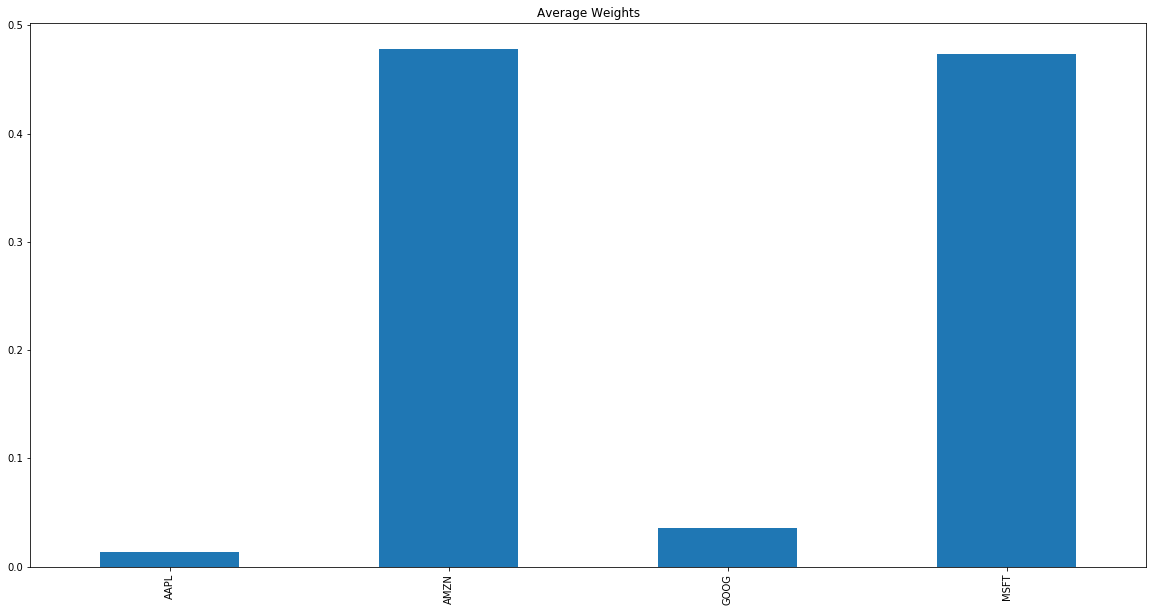

In [39]:
#plot Average weights
pd.Series({list_of_tickers[i]:avg_weights[i] for i in range(len(list_of_tickers))}).plot.bar(figsize=(20, 10), title = 'Average Weights')

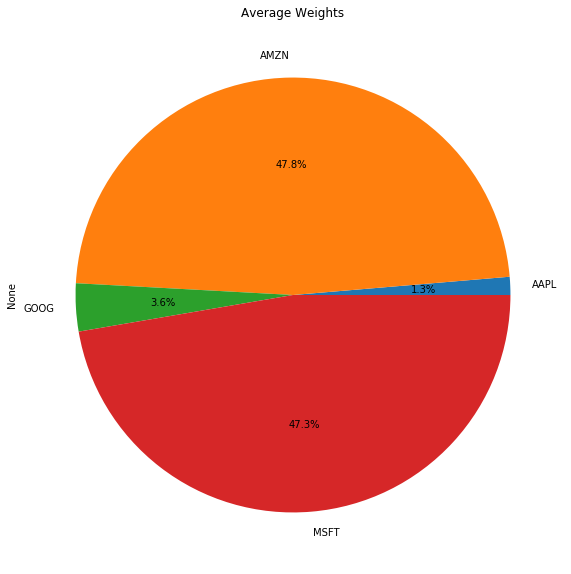

In [40]:
#plot average weights pie chart
pd.Series({list_of_tickers[i]:avg_weights[i] for i in range(len(list_of_tickers))}).plot.pie(autopct='%1.1f%%', figsize=(20, 10), title = 'Average Weights')

In [41]:
# average return after n years 
monte_carlo_avg_opt.iloc[-1]

0     1063.074930
1      471.335542
2     1384.195138
3     2736.762601
4     2009.964471
5      135.419713
6      198.724919
7      538.813299
8       66.805735
9     1266.915215
10     507.982648
11    1096.023581
12      82.946646
13     354.101099
14     256.430381
15     134.997369
16     424.247369
17    1247.667288
18     444.355037
19     524.837310
Name: 7560, dtype: float64

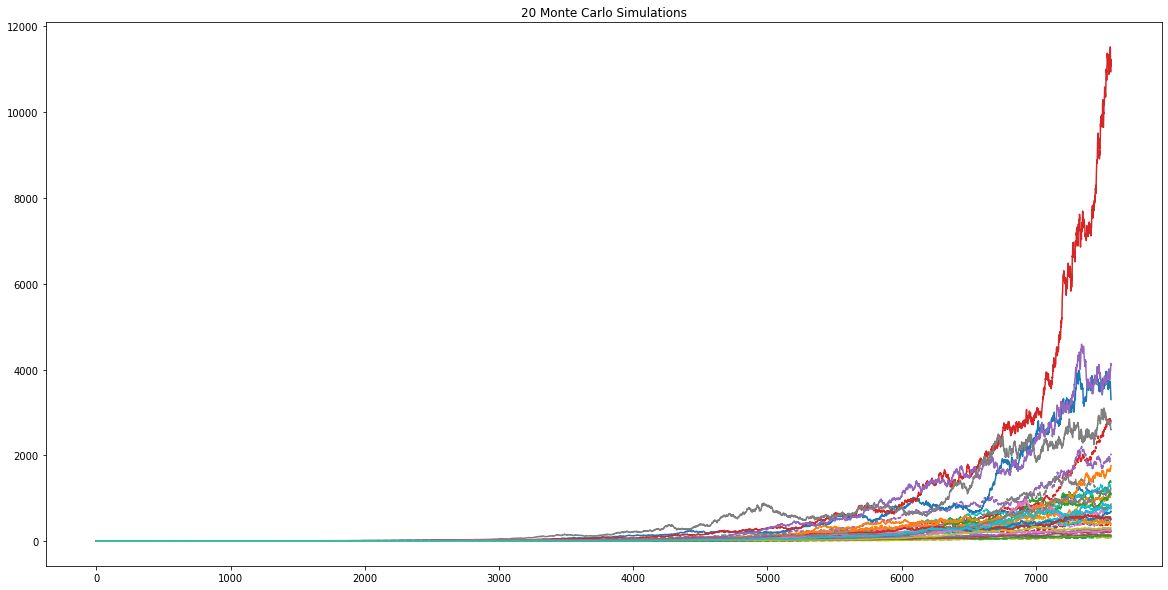

In [42]:
# plot both average weights and optimal weights of all portfolios

ax = monte_carlo_avg_opt.plot(legend=None, style='--', title=f'{number_simulations} Monte Carlo Simulations', figsize=(100,50))
monte_carlo.plot(legend=None, title=f'{number_simulations} Monte Carlo Simulations', figsize=(20,10),ax=ax)

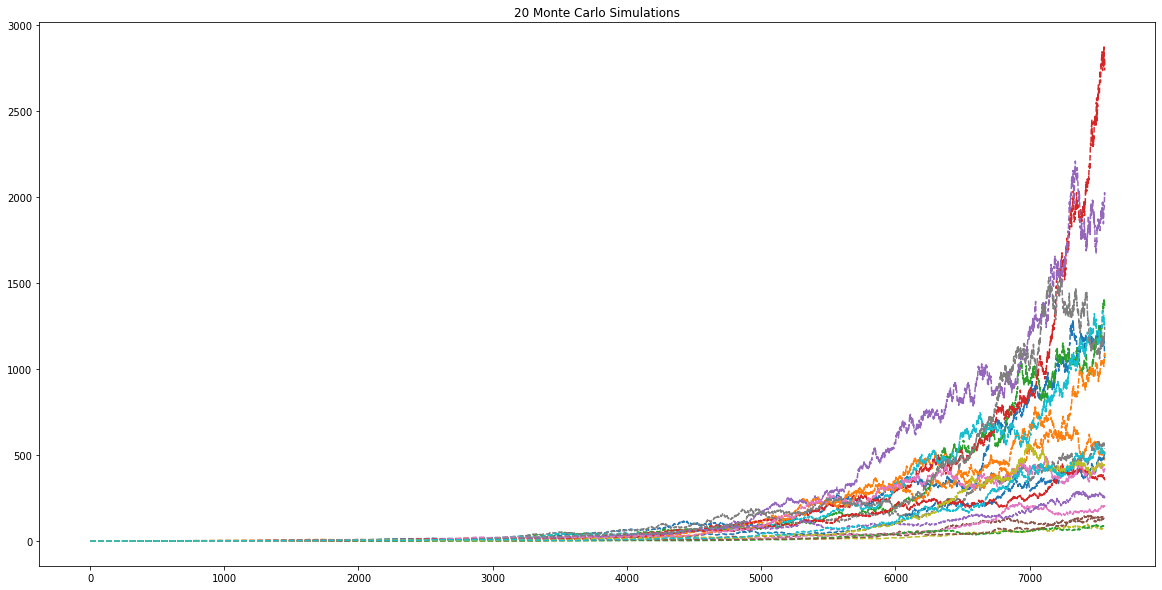

In [43]:
# plot average weights

monte_carlo_avg_opt.plot(legend=None, style='--', title=f'{number_simulations} Monte Carlo Simulations', figsize=(20,10))

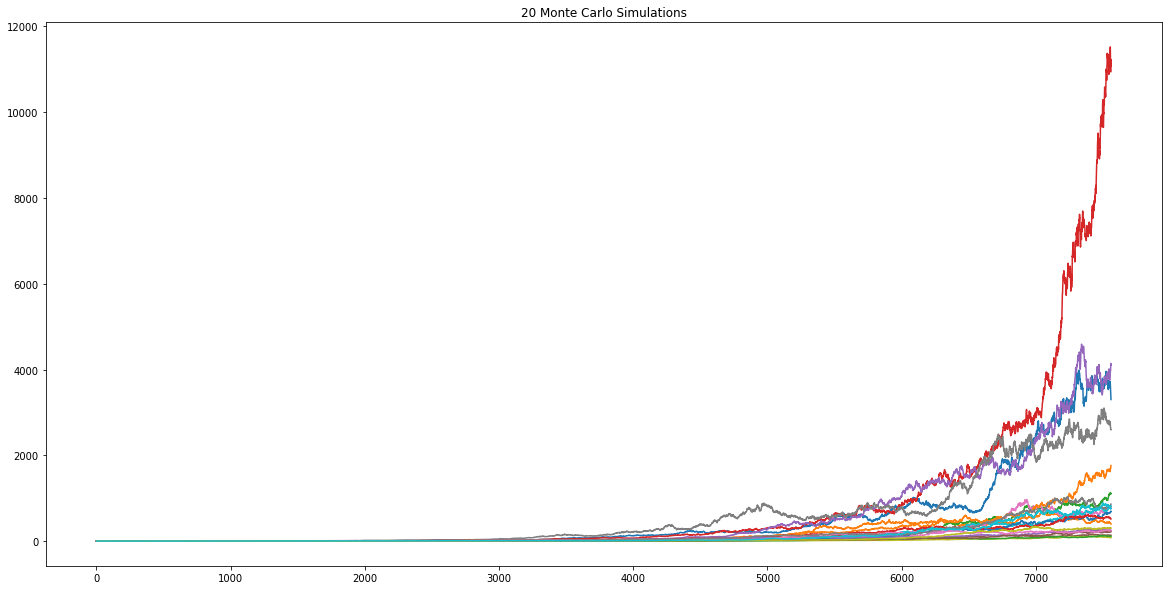

In [44]:
#plot Monte Carlo

monte_carlo.plot(legend=None, title=f'{number_simulations} Monte Carlo Simulations', figsize=(20,10))

# Expected Investment

In [45]:
# expected investment
cumulative_return_last = monte_carlo_avg_opt.iloc[-1]
avg_expected = cumulative_return_last.mean() * init_invstmnt
print(f'With initial investment of {init_invstmnt}, your investment is expected to be: ${round(avg_expected,2)}')

With initial investment of 50000, your investment is expected to be: $37364000.72


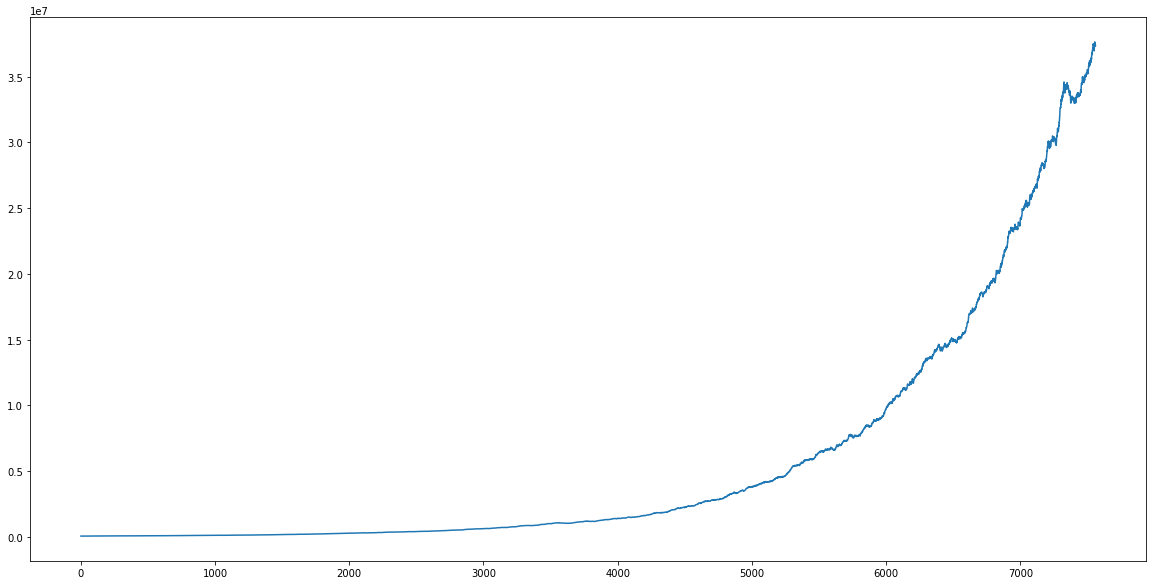

In [46]:
#plot initial investment
(monte_carlo_avg_opt.mean(axis=1) * init_invstmnt).plot(figsize = (20, 10))

# Compare uniform weights with average optimal weights

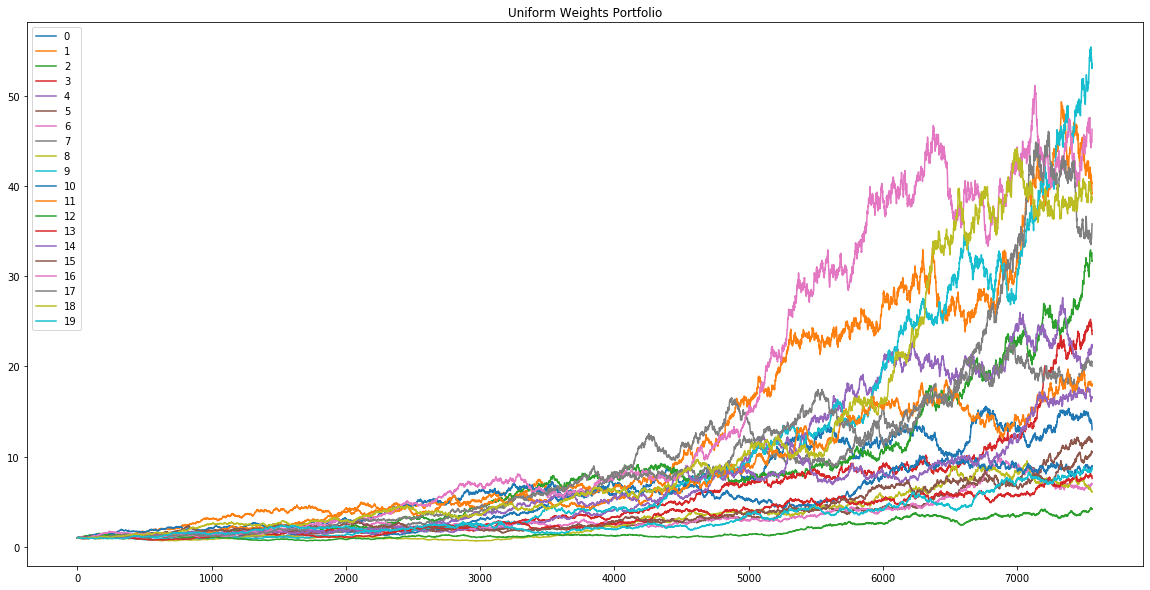

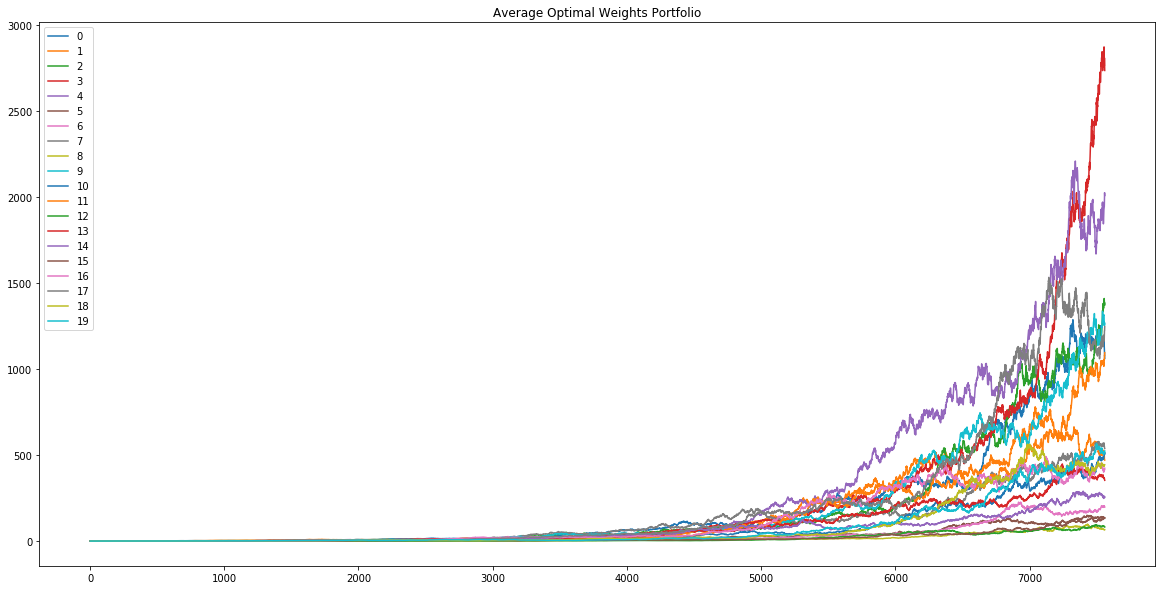

In [47]:
mc_uniform_port_dr.plot(title='Uniform Weights Portfolio', figsize = (20,10))
monte_carlo_avg_opt.plot(title='Average Optimal Weights Portfolio', figsize=(20,10))

# Compare SPY with average optimal portfolio

## A comparison between the simulated SPY prices and portfolio optimal average weights

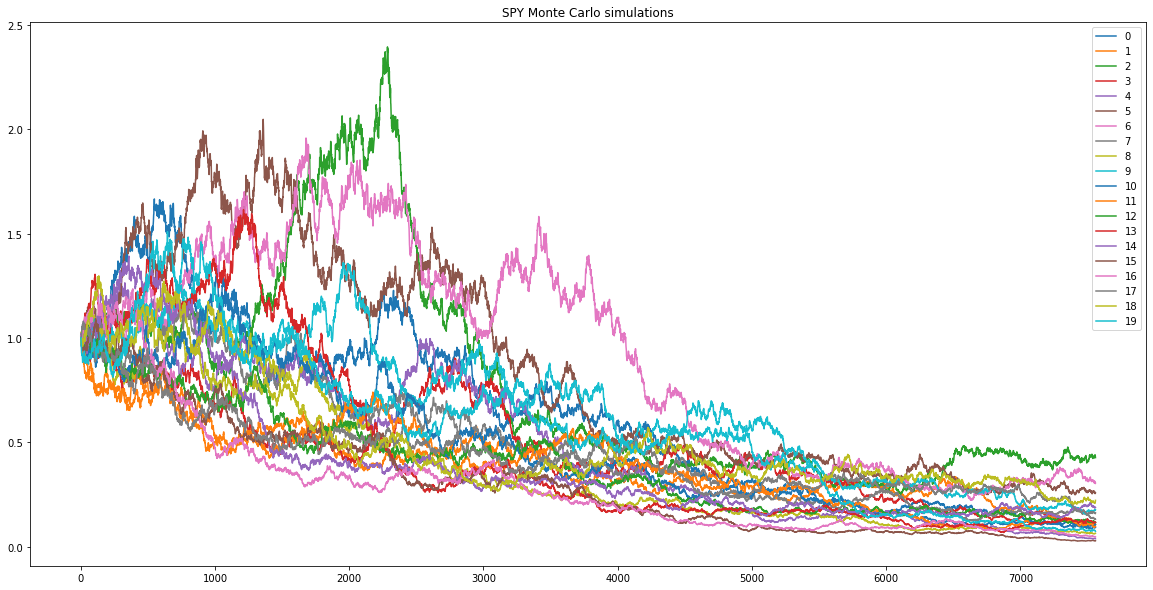

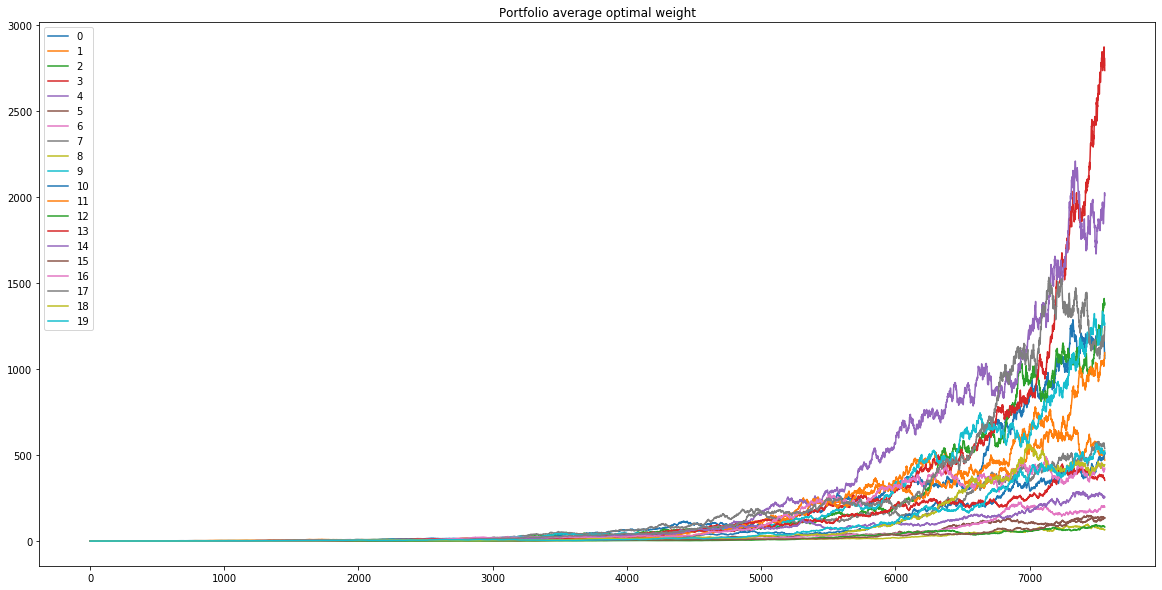

In [48]:
# compare SPY and average optimal portfolio
monte_carlo_spy.plot(title='SPY Monte Carlo simulations', figsize=(20,10))
monte_carlo_avg_opt.plot(title='Portfolio average optimal weight', figsize=(20,10))

In [49]:
confidence_interval = cumulative_return_last.quantile([0.05,0.95])
confidence_interval

0.05      82.139600
0.95    2046.304377
Name: 7560, dtype: float64

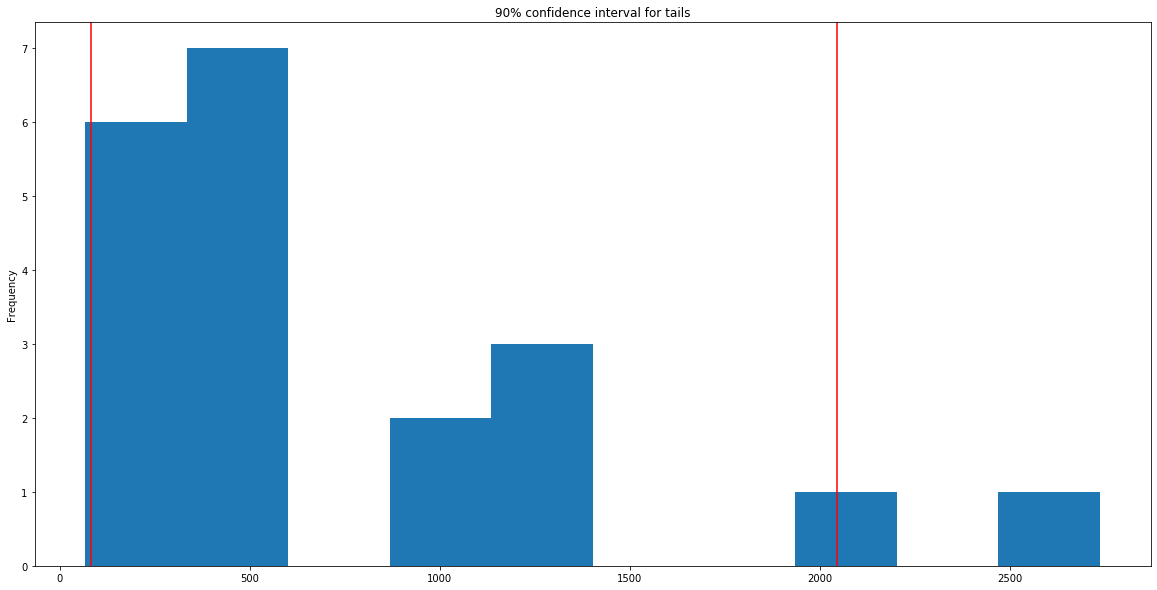

In [50]:
plt.figure()
cumulative_return_last.plot.hist(title="90% confidence interval for tails", figsize = (20,10))
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

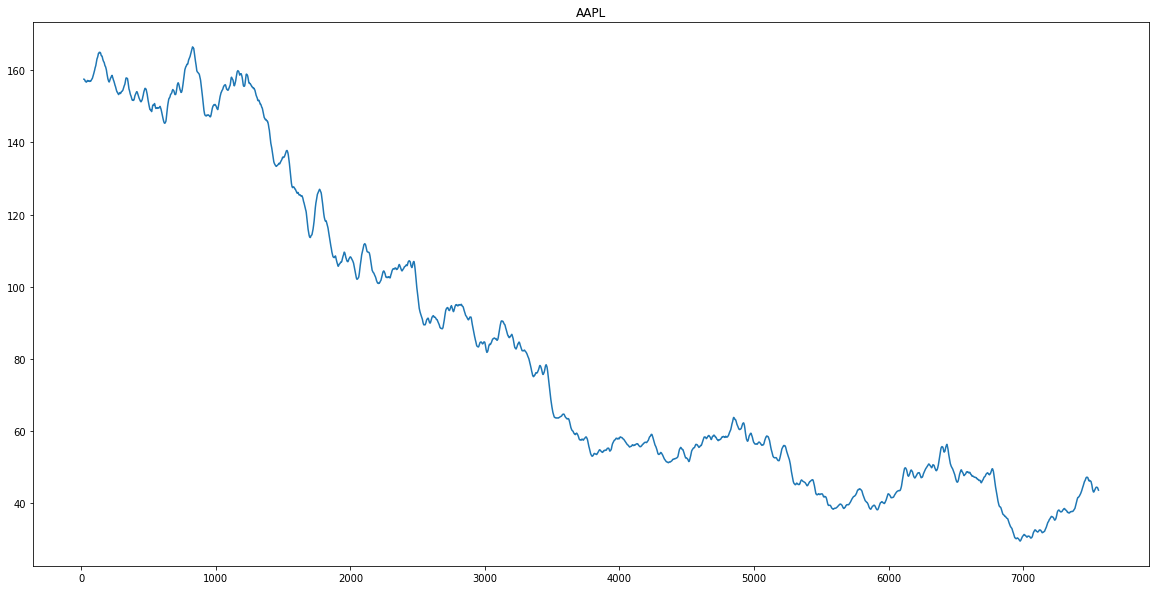

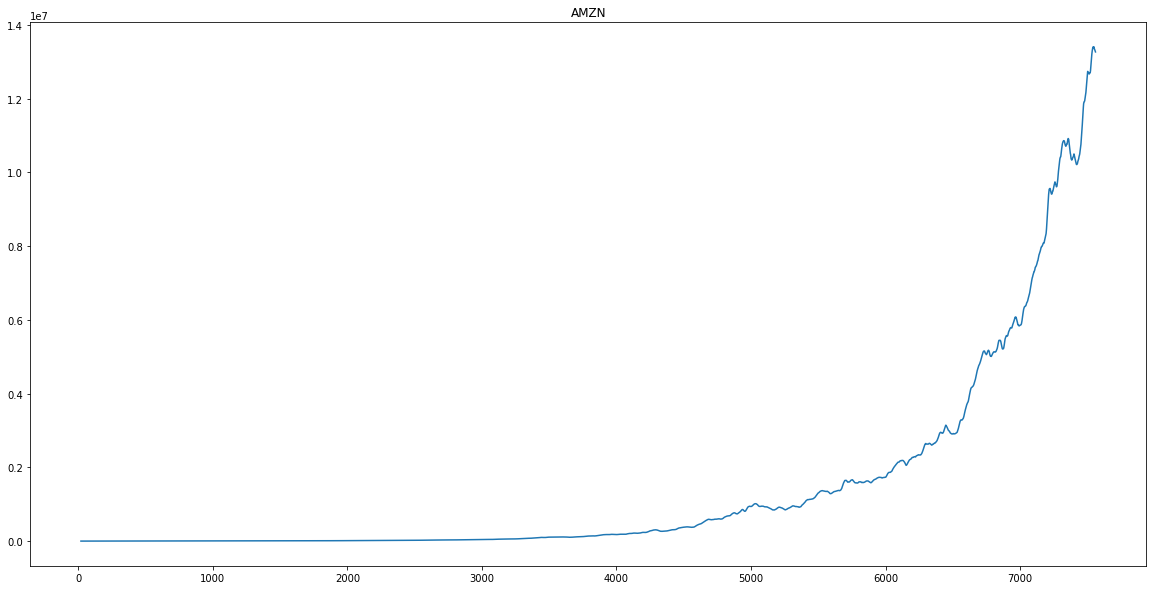

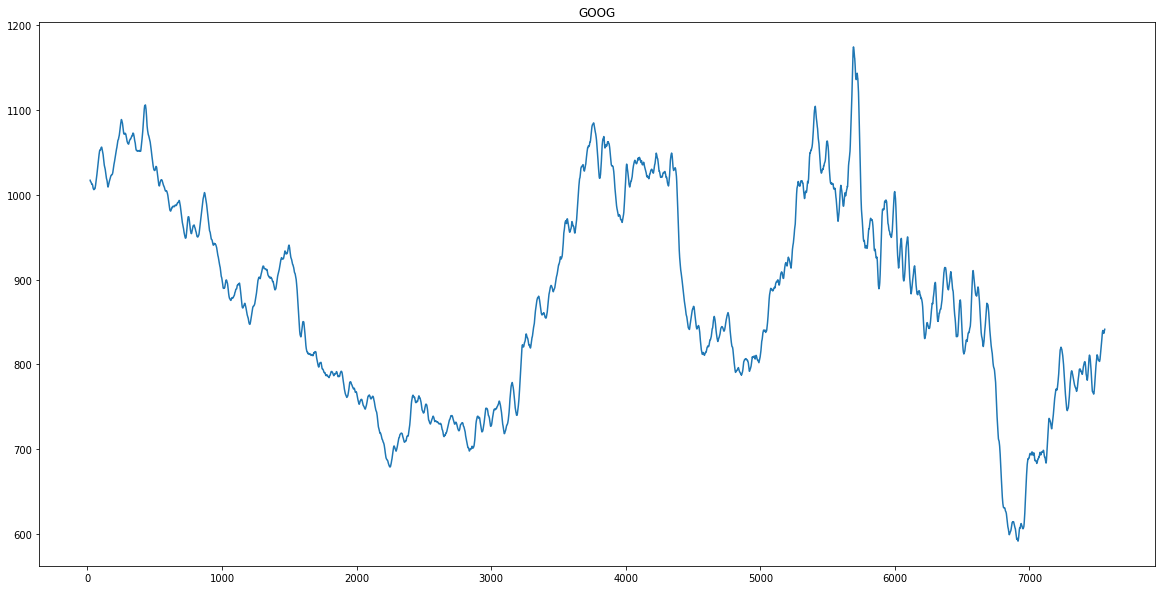

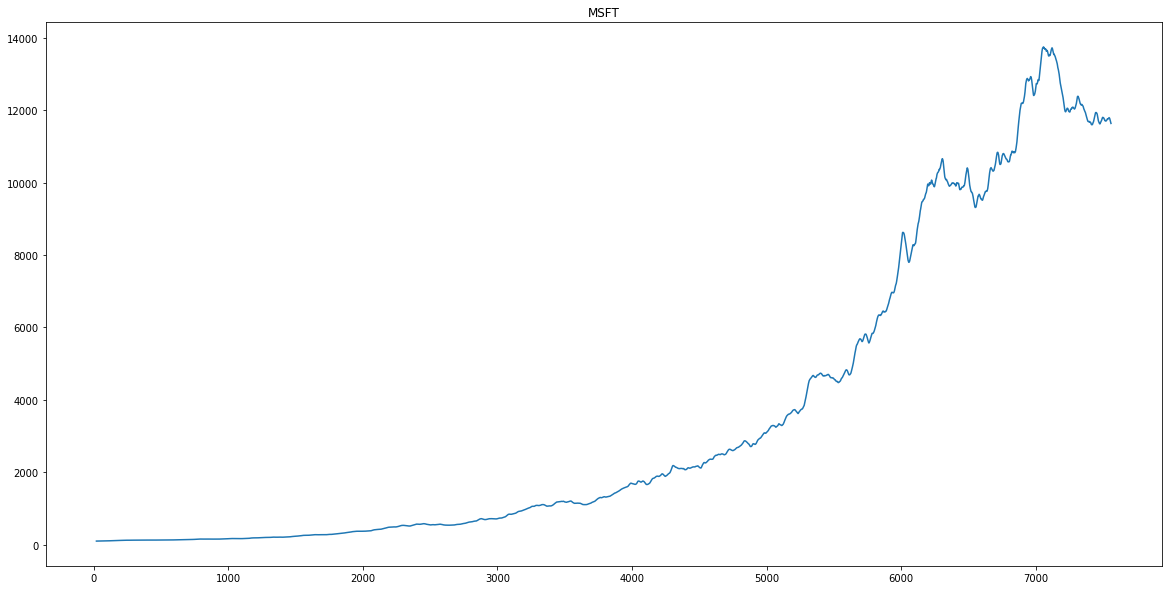

In [51]:
# All simulated prices rolling window
for stock in list_of_tickers:
    plt.figure()
    simulated_prices_all[stock].mean(axis=1).rolling(window=21).mean().plot(title=stock, figsize=(20,10))


In [52]:
correlation = simulated_prices_df.corr()
correlation

,AAPL,AMZN,GOOG,MSFT
AAPL,1.000000,-0.428311,0.584173,-0.394710
AMZN,-0.428311,1.000000,-0.499935,0.799525
GOOG,0.584173,-0.499935,1.000000,-0.463571
MSFT,-0.394710,0.799525,-0.463571,1.000000


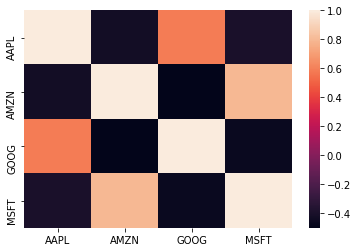

In [53]:
sns.heatmap(correlation)
